## Product Categorization

### Background

The Online Shopping Dataset used for this project is consolidated by Jackson Divakar through web scraping. The dataset presents valuable opportunity in exploring various aspects of online shopping behavior and derive actionable insights to improve business strategies and customer experience.

Divakar has already conducted an initial pre-processing of the dataset and cleaning; however, some generality of product categories was overlooked. The Product Categories column includes categories that refer to the brand instead of the actual category (e.g. Nest-USA, Google, etc.). Also, some Product Ctegories are almost synonymous (like Bottles & Drinkware, More Bags & Backpacks, etc.) which cause multicollinearity (i.e. features that are not independent), negatively impacting our results.

Thus, there are two things that we need to do to have optimal Product Categories:
 - Identify the Product Categories given the Product Description
 - Ensure that each Product Category is distinct/independent from other Product Categories

### Standard Product Categories

To have reliable Product Categories, we need to have a standard. Thus, for this exercise, we used the <a href='https://www.kaggle.com/datasets/lokeshparab/amazon-products-dataset'>Amazon Product Sales</a> dataset  in Kaggle.
The dataset has Name (i.e., Product Description) mapped to one of 22 unique Main_Category values and 140 Sub_Category values (one sheet each). For the purpose of this exercise, we are considering each Main_Category value as Product Category values for generality and simplicity.

From each Sub_Category sheet, we collect the first 500 rows (capped by the no. of rows) and consolidate them into one sheet (.csv file). The resulting dataset (with columns Product is used to train a model for Product Categorization.

In [2]:
import joblib
import os
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.titlesize': 20
})

warnings.filterwarnings('ignore')

In [4]:
curr_dir = os.getcwd()
folder_path = os.path.join(curr_dir, '..', 'archive_amazon')

dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path, usecols=['name', 'main_category'], nrows=500)
        dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)
col_map = {'name': 'Product_Description', 'main_category': 'Product_Category'}
combined_df = combined_df.rename(columns=col_map)

out_folder = os.path.join(curr_dir, '..', 'Data')
os.makedirs(out_folder, exist_ok=True)
out_path = os.path.join(out_folder, 'trainingdataset.csv')
combined_df.to_csv(out_path, index=False)

print(f"Product Categories training dataset saved to {out_path}.")

Product Categories training dataset saved to /home/msds-pt2025b/ftallo/dmw/FinalProject/Notebooks/../Data/trainingdataset.csv.


### Support Vector Machines (SVM)

The model used for Product Categorization is the Support Vector Machine (SVM).

SVMs are supervised learning models used for classification and regression tasks. The SVM model works by finding the optimal hyperplane that best separates classes in the feature space. The hyperplane is chosen to maximize the margin (distance between the hyperplane and the nearest data points from each class) known as support vectors. This hyperplane is determined by solving an optimization problem - minimizing the classification error while maximizing the margin. SVMs can be used for both linear and non-linear classification tasks through the use of different kernel functions (e.g., linear, radial basis function (RBF), etc). These kernels allow SVMs to handle non-linear decision boundaries by mapping the original feature space into a higher-dimensional space where the classes become separable. The C parameter is is a penalty parameter if the error term - when it is large, it will aim to classify all the training dataset correctly (complex decision boundary), when it is low, it will allow misclassifications in the training dataset (simpler decision boundary)

<img src='../Data/SVM.png' width=500/>
Source: <a href='https://scikit-learn.org/stable/modules/svm.html'>Support Vector Machines</a>

### Model Training - Code & Documentation

The model is trained to predict the Product Categories given a Product Description. The model is generated via the following steps.
1. Loads and pre-processes the training data.
2. Vectorizes it into a Bag-of-Words representation (BoW) with TF-IDF.
3. Determines the optimal number of SVD components based on a target cumulative explained varianec (CEV).
4. Reduces dimensionality via Truncated SVD
5. Trains the model via Support Vector Machine (SVM) classifier.
6. Saves the vectorizer, SVD, and trained SVM model to disk for later use.
 
 #### 1. Loading and Pre-processing of Training Data
Once the training data is loaded, it is pre-processed first via the `prod_preprocess` function.
This function takes a text string (i.e. Product_Description) as input and performs several preprocessing steps.
- Tokenizes the text.
- Converts tokens to lowercase.
- Lemmatizes each token.
- Removes non-alphabetic tokens, short tokens, and stopwords.
- Joins the processed tokens back into a single string.
 
 #### 2. Vectorizing into BoW Representation via TF-IDF
The `prod_vectorize` function vectorizes the preprocessed text data using TF-IDF.
 - Initializes a TfidfVectorizer with the specified parameters.
 - Fits the vectorizer to the text data and transforms the data.
 - Saves the vectorizer to disk.
 - Removes rows with no non-zero entries.
 - Returns the transformed data, feature names, and corresponding labels.
 
 #### 3. Getting the Optimal Number of SVD Components
The `get_ncp` function determines the optimal number of components for SVD to achieve a target cumulative explained variance (CEV).
 - Performs SVD on the vectorized data.
 - Calculates the cumulative explained variance ratio.
 - Identifies the number of components required to reach the target CEV (set at 95%).
 - Plots the cumulative explained variance ratio against the number of components.
 
 #### 4. Reducing Dimensionality via SVD
The vectorized data from step 2 is tranformed via SVD - reducing the features/columns from BoW representation to `n` SVD components as determined by step 3 (determined to be 345 components).

 #### 5. Training the SVM Model
To handle class imbalance (unequal count of Product Categories in the training data), weights are calculated for the SVM classifier. The SVM model is then trained with the SVD-transformed training data.

 #### 6. Saving the Vectorizer, SVD, and Trained SVM Model
The vectorizer, SVD, and the trained SVM model are saved for later use - specifically for the cross-validation and prediction steps.

 

Vectorizer saved to /home/msds-pt2025b/ftallo/dmw/FinalProject/Notebooks/../Models/vectorizer.joblib.
Design Matrix shape: (53618, 812)
No. of components for 95% explained variance: 345


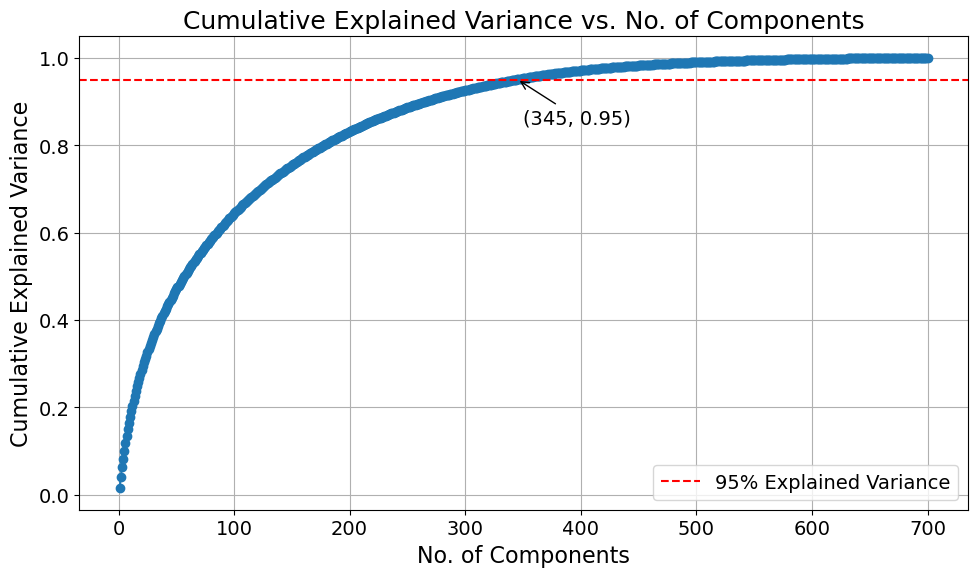

SVD saved to /home/msds-pt2025b/ftallo/dmw/FinalProject/Notebooks/../Models/svd.joblib.
Left SV shape: (53618, 345)
SVM model saved to /home/msds-pt2025b/ftallo/dmw/FinalProject/Notebooks/../Models/svm_model_cev95.joblib.


In [6]:
# vectorization takes 19.24s to complete
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
curr_dir = os.getcwd()
out_folder = os.path.join(curr_dir, '..', 'Models')
os.makedirs(out_folder, exist_ok=True)
maxf = 10000
cev = 0.95


def prod_preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens
              if token.isalpha() and len(token) > 2 and
              token not in stop_words]
    return ' '.join(tokens)


def prod_vectorize(X, Y):
    args = {'max_features': maxf, 'tokenizer': prod_preprocess,
            'ngram_range': (1, 2)}
    vectorizer = TfidfVectorizer(**args)  # Include bigrams, trigrams
    X_vec = vectorizer.fit_transform(X)
    vectorizer_path = os.path.join(out_folder, 'vectorizer.joblib')
    joblib.dump(vectorizer, vectorizer_path)
    print(f'Vectorizer saved to {vectorizer_path}.')
    nonzeros = X_vec.sum(axis=1).nonzero()[0]
    X_vec = X_vec[nonzeros]
    Y = [Y[i] for i in nonzeros.tolist()]
    print(f'Design Matrix shape: {X_vec.shape}')  # full data is (18846, 134410)
    return X_vec, vectorizer.get_feature_names_out(), Y


def get_ncp(X_vec, ncp_max=700, target_cev=0.9):
    # svd takes 58.05s to complete
    svd = TruncatedSVD(n_components=ncp_max)  # Start with a reasonable number of components
    svd.fit_transform(X_vec)

    # Calculate cumulative explained variance ratio
    cum_exp_var = np.cumsum(svd.explained_variance_ratio_)
    ncp = np.argmax(cum_exp_var >= target_cev) + 1
    print(f"No. of components for {target_cev*100:.0f}% explained variance:", ncp)

    # Plotting cumulative explained variance ratio
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(cum_exp_var) + 1), cum_exp_var, marker='o')
    plt.axhline(y=target_cev, color='r', linestyle='--', label=f'{target_cev*100:.0f}% Explained Variance')
    plt.xlabel('No. of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance vs. No. of Components')
    plt.annotate(f'({ncp}, {cum_exp_var[ncp - 1]:.2f})',
                 xy=(ncp, cum_exp_var[ncp - 1]),
                 xytext=(ncp + 5, cum_exp_var[ncp - 1] - 0.1),
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 )
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return ncp


file_path = os.path.join(curr_dir, '..', 'Data', 'trainingdataset.csv')
df = pd.read_csv(file_path, usecols=['name', 'main_category', 'sub_category'])
X_train = df['name'].values.tolist()
Y_train = df['main_category'].values.tolist()
X_train_vec, X_train_featnms, Y_train = prod_vectorize(X_train, Y_train)

ncp = get_ncp(X_train_vec, target_cev=cev)
svd = TruncatedSVD(n_components=ncp)
X_train_svd = svd.fit_transform(X_train_vec)
svd_path = os.path.join(out_folder, f'svd.joblib')
joblib.dump(svd, svd_path)
print(f'SVD saved to {svd_path}.')
print(f'Left SV shape: {X_train_svd.shape}')  # full data is (18846, 134410)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)
class_weight_dict = {cls: weight for cls, weight in zip(np.unique(Y_train), class_weights)}

# Initialize the SVM model
svm = SVC(class_weight=class_weight_dict, kernel='rbf', C=10)
# Save the final model trained on the entire dataset
svm.fit(X_train_svd, Y_train)
model_path = os.path.join(out_folder, f'svm_model_cev{cev*100:.0f}.joblib')
joblib.dump(svm, model_path)

print(f'SVM model saved to {model_path}.')

### Model Performance - Code & Documentation

In the provided code, we use two different cross-validation techniques to evaluate the performance of an SVM classifier trained on a dataset. These techniques are Monte-Carlo Cross-Validation and 5-Fold Cross-Validation. Additionally, we compare the metrics of Accuracy and F1-Score to assess the model's performance.

#### Monte-Carlo Cross-Validation

Monte-Carlo Cross-Validation, also known as repeated random subsampling validation, involves repeatedly splitting the dataset into training and testing sets, training the model, and evaluating it multiple times. The `run_mccv` function performs the following steps.

 - Randomly split the dataset into training (80%) and testing (20%) sets multiple times.
 - Train the SVM model on the training set and evaluate it on the testing set.
 - Repeat the process for a specified number of splits (n_splits).
 - Calculate the mean and standard deviation of the accuracy and F1-Score across all iterations.
 
The advantage is it provides a robust estimate by averaging over multiple random splits, thus reducing the chance of overfitting.

#### 5-Fold Cross-Validation

5-Fold Cross-Validation involves splitting the dataset into 5 equal parts (folds), using each fold as the testing set once while the remaining 4 folds are used for training. The `run_kfcv` function performs the following steps.

 - Split the dataset into 5 equal parts (folds).
 - For each fold, train the SVM model on the remaining 4 folds and evaluate it on the current fold.
 - Repeat for all 5 folds.
 - Calculate the mean and standard deviation of the accuracy and F1-Score across all folds.
 
The advantage is it uses each data point for both training and testing exactly once, thus proving a more efficient and balance estimate than repeated random splits. 


#### Measuring Performance
To measure model performance, we compare Accuracy and F1-Score metrics.

In [3]:
def run_mccv(svm, X_svd, Y, n_splits=5):
    print('Running Monte Carlo Cross-Validation...')
    mc_accuracies = []
    mc_f1_scores = []

    for _ in range(n_splits):
        X_train_mc, X_test_mc, Y_train_mc, Y_test_mc = train_test_split(X_svd, Y, test_size=0.2, stratify=Y)
        svm.fit(X_train_mc, Y_train_mc)
        Y_pred_mc = svm.predict(X_test_mc)
        mc_accuracies.append(accuracy_score(Y_test_mc, Y_pred_mc))
        mc_f1_scores.append(f1_score(Y_test_mc, Y_pred_mc, average='weighted'))

    print(f'Monte Carlo Cross-Validation Accuracy: {np.mean(mc_accuracies):.4f} ± {np.std(mc_accuracies):.4f}')
    print(f'Monte Carlo Cross-Validation F1-Score: {np.mean(mc_f1_scores):.4f} ± {np.std(mc_f1_scores):.4f}')


def run_kfcv(svm, X_svd, Y, n_splits=5):
    print(f'Running {n_splits}-Fold Cross-Validation...')
    kf = KFold(n_splits=n_splits, shuffle=True)
    kf_accuracies = []
    kf_f1_scores = []

    for train_index, test_index in kf.split(X_svd):
        X_train_kf, X_test_kf = X_svd[train_index], X_svd[test_index]
        Y_train_kf, Y_test_kf = np.array(Y)[train_index], np.array(Y)[test_index]
        svm.fit(X_train_kf, Y_train_kf)
        Y_pred_kf = svm.predict(X_test_kf)
        kf_accuracies.append(accuracy_score(Y_test_kf, Y_pred_kf))
        kf_f1_scores.append(f1_score(Y_test_kf, Y_pred_kf, average='weighted'))

    print(f'K-Fold Cross-Validation Accuracy: {np.mean(kf_accuracies):.4f} ± {np.std(kf_accuracies):.4f}')
    print(f'K-Fold Cross-Validation F1-Score: {np.mean(kf_f1_scores):.4f} ± {np.std(kf_f1_scores):.4f}')


run_mccv(svm, X_train_svd, Y_train)
run_kfcv(svm, X_train_svd, Y_train)

print('\nProcess Complete.')

Running Monte Carlo Cross-Validation...
Monte Carlo Cross-Validation Accuracy: 0.7996 ± 0.0025
Monte Carlo Cross-Validation F1-Score: 0.7982 ± 0.0024
Running 5-Fold Cross-Validation...
K-Fold Cross-Validation Accuracy: 0.7972 ± 0.0013
K-Fold Cross-Validation F1-Score: 0.7955 ± 0.0014

Process Complete.


### Model Performance - Best Parameters

To find the best parameters in maximizing model perforance, a grid search was performed - testing several parameter combinations that generate the best SVM model.
As the process takes a long time to complete, the results are summarized in the plot.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define the pipeline with TruncatedSVD and SVM
svd = TruncatedSVD()
svm = SVC(class_weight='balanced', kernel='linear')
pipeline = Pipeline([('svd', svd), ('svm', svm)])

# Define the parameter grid for grid search
param_grid = {
    'svd__n_components': [266, 345, 504],  # cevs: 90, 95, 99
    'svm__C': [0.1, 1, 10],  # SVM's C parameter
    'svm__kernel': ['linear', 'rbf'],  # SVM's kernel types
}

# Create GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_vec, Y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Retrain the pipeline with the best parameters
pipeline.set_params(**best_params)
pipeline.fit(X_train_vec, Y_train)

# Save the final model trained on the entire dataset
model_path = os.path.join(out_folder, 'svm_model_best.joblib')
joblib.dump(pipeline, model_path)
print(f'SVM model saved to {model_path}.')

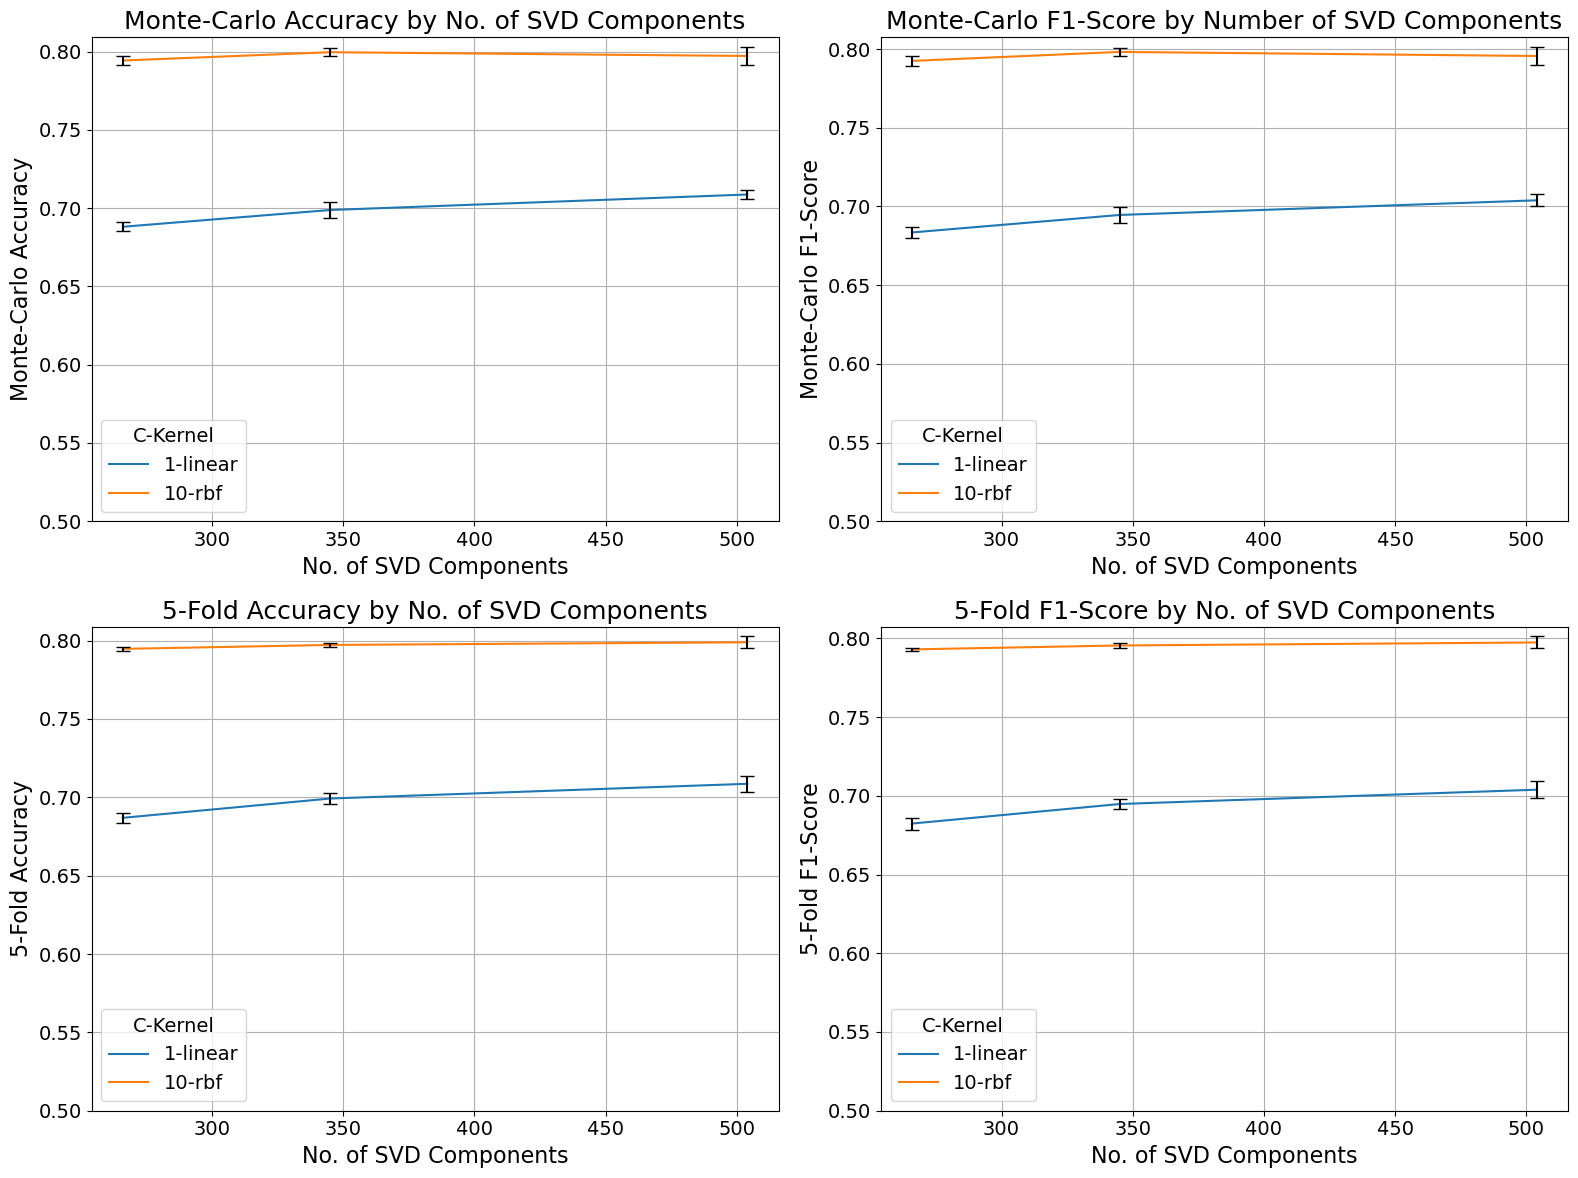

In [7]:
data = {
    "ncp": [266, 345, 504, 266, 345, 504],
    "C-kernel": ["1-linear", "1-linear", "1-linear", "10-rbf", "10-rbf", "10-rbf"],
    "MC-Acc": [0.6881, 0.6988, 0.7087, 0.7943, 0.7996, 0.7972],
    "MC-F1": [0.6835, 0.6946, 0.7039, 0.7925, 0.7982, 0.7956],
    "5F-Acc": [0.6869, 0.6992, 0.7086, 0.7947, 0.7972, 0.7989],
    "5F-F1": [0.6824, 0.6948, 0.7039, 0.793, 0.7955, 0.7974],
    "MC-AccSD": [0.003, 0.0049, 0.0031, 0.0031, 0.0025, 0.006],
    "MC-F1SD": [0.0033, 0.0049, 0.0037, 0.0032, 0.0024, 0.0058],
    "5F-AccSD": [0.0033, 0.0034, 0.0051, 0.0012, 0.0013, 0.0039],
    "5F-F1SD": [0.0038, 0.0031, 0.0054, 0.0011, 0.0014, 0.0038]
}

df = pd.DataFrame(data)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Monte-Carlo Accuracy
sns.lineplot(ax=axes[0, 0], x="ncp", y="MC-Acc", hue="C-kernel", markers=True, dashes=False, data=df)
for i in range(df.shape[0]):
    row = df.iloc[i]
    axes[0, 0].errorbar(row['ncp'], row['MC-Acc'], yerr=row['MC-AccSD'], fmt='none', capsize=5, color='black')
axes[0, 0].set_title('Monte-Carlo Accuracy by No. of SVD Components')
axes[0, 0].set_xlabel('No. of SVD Components')
axes[0, 0].set_ylabel('Monte-Carlo Accuracy')
axes[0, 0].legend(title='C-Kernel')
axes[0, 0].grid(True)
axes[0, 0].set_ylim(0.5)

# Monte-Carlo F1-Score
sns.lineplot(ax=axes[0, 1], x="ncp", y="MC-F1", hue="C-kernel", markers=True, dashes=False, data=df)
for i in range(df.shape[0]):
    row = df.iloc[i]
    axes[0, 1].errorbar(row['ncp'], row['MC-F1'], yerr=row['MC-F1SD'], fmt='none', capsize=5, color='black')
axes[0, 1].set_title('Monte-Carlo F1-Score by Number of SVD Components')
axes[0, 1].set_xlabel('No. of SVD Components')
axes[0, 1].set_ylabel('Monte-Carlo F1-Score')
axes[0, 1].legend(title='C-Kernel')
axes[0, 1].grid(True)
axes[0, 1].set_ylim(0.5)

# 5-Fold Accuracy
sns.lineplot(ax=axes[1, 0], x="ncp", y="5F-Acc", hue="C-kernel", markers=True, dashes=False, data=df)
for i in range(df.shape[0]):
    row = df.iloc[i]
    axes[1, 0].errorbar(row['ncp'], row['5F-Acc'], yerr=row['5F-AccSD'], fmt='none', capsize=5, color='black')
axes[1, 0].set_title('5-Fold Accuracy by No. of SVD Components')
axes[1, 0].set_xlabel('No. of SVD Components')
axes[1, 0].set_ylabel('5-Fold Accuracy')
axes[1, 0].legend(title='C-Kernel')
axes[1, 0].grid(True)
axes[1, 0].set_ylim(0.5)

# 5-Fold F1-Score
sns.lineplot(ax=axes[1, 1], x="ncp", y="5F-F1", hue="C-kernel", markers=True, dashes=False, data=df)
for i in range(df.shape[0]):
    row = df.iloc[i]
    axes[1, 1].errorbar(row['ncp'], row['5F-F1'], yerr=row['5F-F1SD'], fmt='none', capsize=5, color='black')
axes[1, 1].set_title('5-Fold F1-Score by No. of SVD Components')
axes[1, 1].set_xlabel('No. of SVD Components')
axes[1, 1].set_ylabel('5-Fold F1-Score')
axes[1, 1].legend(title='C-Kernel')
axes[1, 1].grid(True)
axes[1, 1].set_ylim(0.5)

plt.tight_layout()
plt.show()

**Effect of C Parameter in SVM**
- When C=1, SVM focuses on finding a wider margin even if it results in misclassifying some training points. This can lead to a simpler model with potentially higher bias but lower variance.
- When C=10, SVM prioritizes correct classification of all training points, even if it means having a narrower margin. This can result in a more complex model with lower bias but higher variance.

**Effect of Kernel in SVM**
- Linear Kernel is suitable for linearly separable data, it assumes a linear decision boundary between classes.
- RBF (Radial Basis Function) Kernel is effective for non-linearly separable data, it maps data points into a higher-dimensional space using a Gaussian function, allowing for more complex decision boundaries.

#### Summary

- The **RBF Kernel with C=10** consistently outperforms the **Linear Kernel with C=1** in terms of both accuracy and F1-score across Monte-Carlo and 5-Fold cross-validation techniques.
- Increasing the number of components generally improves the performance for both kernels.
- The low standard deviations across all metrics and configurations suggest that the model's performance is stable and reliable.


#### Final SVM Model Hyperparameters

The no. of SVD components (266, 345, and 504) correspond to the the target cumulative explained variance (CEV) (90%, 95%, and 99%). As we increase the no. of SVD component, the run time also increases which significantly impacts model training (considering that there 53618 rows in the training dataset). Thus, due to the minimal return in accuracy/F1-score with increasesing the no. of components, the following optimal no. of components/hyperparameters are used for the final SVM model:

\begin{align*} \text{No. of SVD Components} &= 345 \end{align*}
\begin{align*} \text{C} &= 10 \end{align*}
\begin{align*} \text{Kernel} &= \text{RBF} \end{align*}

**Model Performance Summary**
 - Monte Carlo Cross-Validation Accuracy: 0.7996 ± 0.0025
 - Monte Carlo Cross-Validation F1-Score: 0.7982 ± 0.0024
 - K-Fold Cross-Validation Accuracy: 0.7972 ± 0.0013
 - K-Fold Cross-Validation F1-Score: 0.7955 ± 0.0014

### Model Prediction
To test the SVM model, the respective model is loaded from disk - along with the vectorizer and SVD.
The `predict_cat` function accepts the vectorizer, SVD, SVM model, as well as the Product_Description to be predicted.
A test run of the function returns the predicted Product_Category for the passed Product_Description.

In [8]:
cev = 0.95
ncp = 345
curr_dir = os.getcwd()
in_folder = os.path.join(curr_dir, '..', 'Models')
vectorizer_path = os.path.join(in_folder, 'vectorizer.joblib')
svd_path = os.path.join(in_folder, 'svd.joblib')
model_path = os.path.join(in_folder, f'svm_model_cev{cev*100:.0f}.joblib')
vectorizer = joblib.load(vectorizer_path)
svd = joblib.load(svd_path)
svm = joblib.load(model_path)

print(f'Vectorizer loaded from {vectorizer_path}.')
print(f'SVD loaded from {svd_path}.')
print(f'SVM model loaded from {model_path}.')


def predict_cat(vectorizer, svd, model, phrase):
    X_new = vectorizer.transform(phrase)
    X_new_svd = svd.transform(X_new)
    predicted_category = model.predict(X_new_svd)[0]
    return predicted_category


predict_cat(vectorizer, svd, svm, ['black shirt'])

Vectorizer loaded from /home/msds-pt2025b/ftallo/dmw/FinalProject/Notebooks/../Models/vectorizer.joblib.
SVD loaded from /home/msds-pt2025b/ftallo/dmw/FinalProject/Notebooks/../Models/svd.joblib.
SVM model loaded from /home/msds-pt2025b/ftallo/dmw/FinalProject/Notebooks/../Models/svm_model_cev95.joblib.


"men's clothing"

### Predicted Categories on the Online Shopping Dataset

Finally, we use the SVM model to predict the Product_Category of each Product_Description in the Online Shopping Dataset (loaded from disk). The output file contains three columns - Product_Description, Product_Category (original product categories from the dataset), and Predicted_Category (from the SVM model).

In [10]:
# Generate csv of predicted categories from our data (Product Description).
curr_dir = os.getcwd()
folder_path = os.path.join(curr_dir, '..', 'Data')
input_file = os.path.join(folder_path, 'shopping_dataset.csv')
df = pd.read_csv(input_file, usecols=['Product_Description', 'Product_Category'])
pred_cats = [predict_cat(vectorizer, svd, svm, [s]) for s in df['Product_Description'].values]
df['Predicted_Category'] = pred_cats

output_file = os.path.join(folder_path, 'prod_categories.csv')
df.to_csv(output_file, index=False)

print(f"Predicted categories saved to {output_file}")

Predicted categories saved to /home/msds-pt2025b/ftallo/dmw/FinalProject/Notebooks/../Data/prod_categories.csv
